# KTR Example

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format', lambda x: '%.5f' % x)
import matplotlib
import matplotlib.pyplot as plt

import orbit
from orbit.models import KTRLite, KTR

from orbit.utils.features import make_fourier_series_df, make_fourier_series
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components
from orbit.diagnostics.metrics import smape
from orbit.utils.dataset import load_iclaims, load_electricity_demand

In [3]:
orbit.__version__

'1.1.1dev'

## Data

In [4]:
df = load_iclaims()

DATE_COL = 'week'
RESPONSE_COL = 'claims'

print(df.shape)

df.head()

(443, 7)


,week,claims,trend.unemploy,trend.filling,trend.job,sp500,vix
0,2010-01-03,13.38660,0.21988,-0.31845,0.11750,-0.41763,0.12265
1,2010-01-10,13.62422,0.21988,-0.19484,0.16879,-0.42548,0.11044
2,2010-01-17,13.39874,0.23614,-0.29248,0.11750,-0.46523,0.53234
3,2010-01-24,13.13755,0.20335,-0.19484,0.10692,-0.48175,0.42864
4,2010-01-31,13.19676,0.13436,-0.24247,0.07448,-0.48893,0.48740


In [5]:
print(f'starts with {df[DATE_COL].min()}\nends with {df[DATE_COL].max()}\nshape: {df.shape}')

starts with 2010-01-03 00:00:00
ends with 2018-06-24 00:00:00
shape: (443, 7)


In [6]:
test_size = 52

train_df = df[:-test_size]
test_df = df[-test_size:]

## KTR

### KTR - Full

### zero regression_segments

In [7]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
#     regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
        regressor_col=['trend.unemploy'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    regression_segments=0,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [8]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [9]:
coef_df = ktr.get_regression_coefs()
coef_df

,week,trend.unemploy
0,2010-01-03,0.11133
1,2010-01-10,0.11133
2,2010-01-17,0.11133
3,2010-01-24,0.11133
4,2010-01-31,0.11133
...,...,...
386,2017-05-28,0.11133
387,2017-06-04,0.11133
388,2017-06-11,0.11133
389,2017-06-18,0.11133


In [10]:
knot_df = ktr.get_regression_coef_knots()
knot_df

,week,step,trend.unemploy
0,2010-01-03,0,0.11133


In [11]:
ktr.get_regression_coefs().head()

,week,trend.unemploy
0,2010-01-03,0.11133
1,2010-01-10,0.11133
2,2010-01-17,0.11133
3,2010-01-24,0.11133
4,2010-01-31,0.11133


In [12]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy
0,2010-01-03,0,0.11133


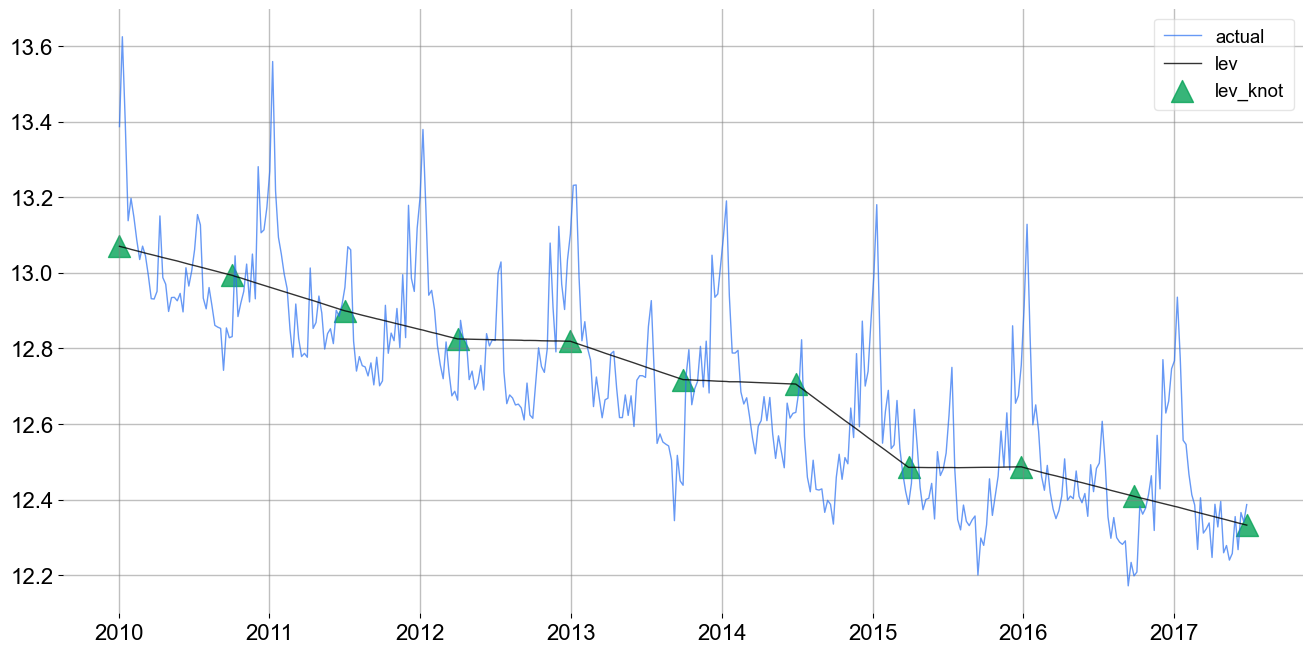

In [13]:
ktr.plot_lev_knots(figsize=(16, 8));

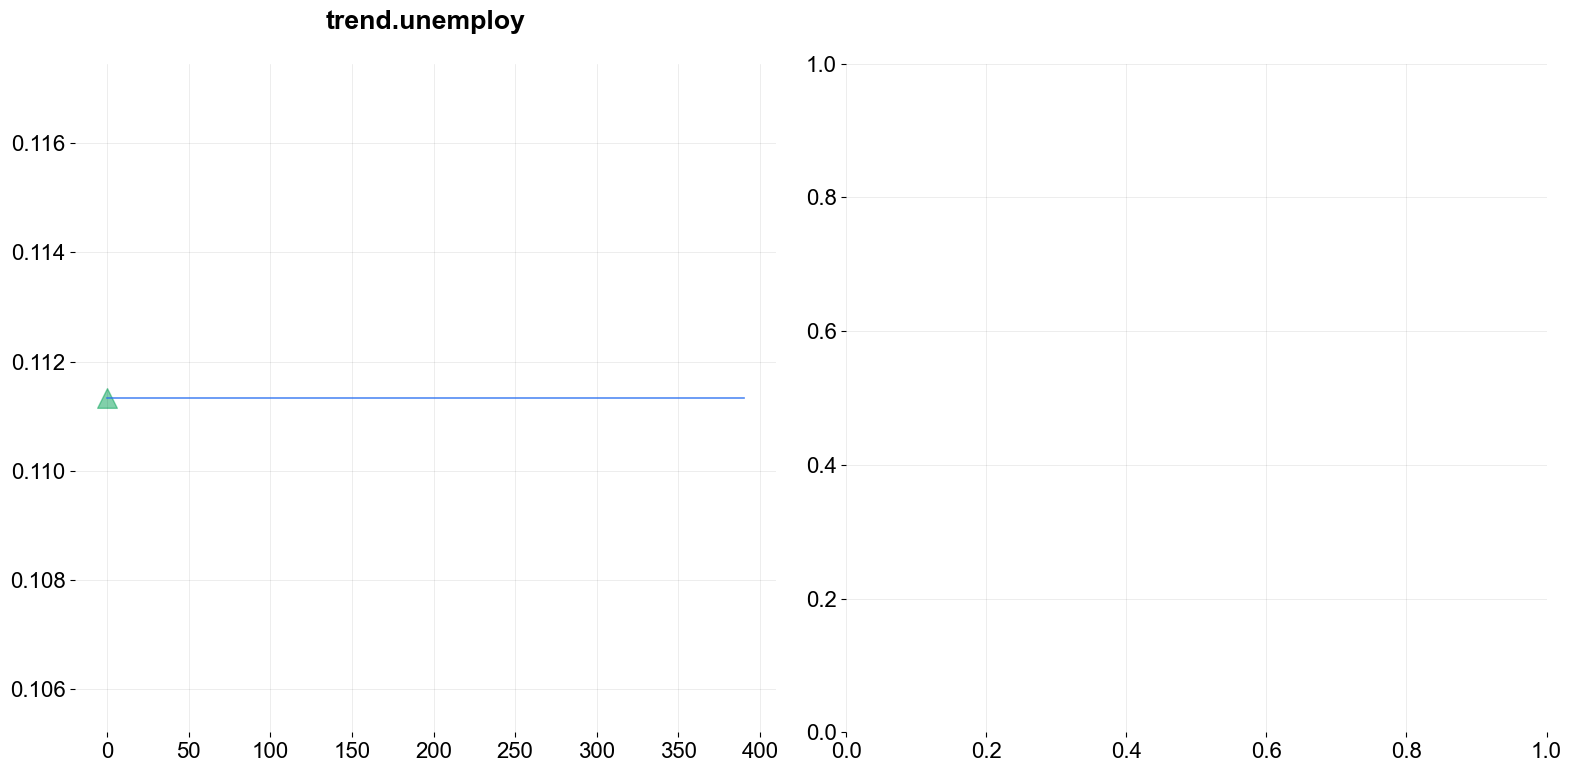

In [14]:
ktr.plot_regression_coefs(with_knot=True, include_ci=False, figsize=(16, 8));

In [15]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.17838,12.33790,12.50381,12.16823,12.32643,12.49294,0.01619,0.02448,0.03239,-0.01367,-0.01367,-0.01367
1,2017-07-09,12.18162,12.34409,12.49487,12.17924,12.33698,12.49276,0.01856,0.02807,0.03714,-0.02090,-0.02090,-0.02090
2,2017-07-16,12.15972,12.31751,12.48736,12.17288,12.33029,12.49706,0.01373,0.02077,0.02748,-0.03211,-0.03211,-0.03211
3,2017-07-23,12.13962,12.30537,12.45551,12.16750,12.33355,12.48392,0.01248,0.01887,0.02496,-0.04732,-0.04732,-0.04732
4,2017-07-30,12.12383,12.28083,12.43928,12.16915,12.32692,12.48546,0.01373,0.02077,0.02748,-0.06621,-0.06621,-0.06621


In [16]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.71%'

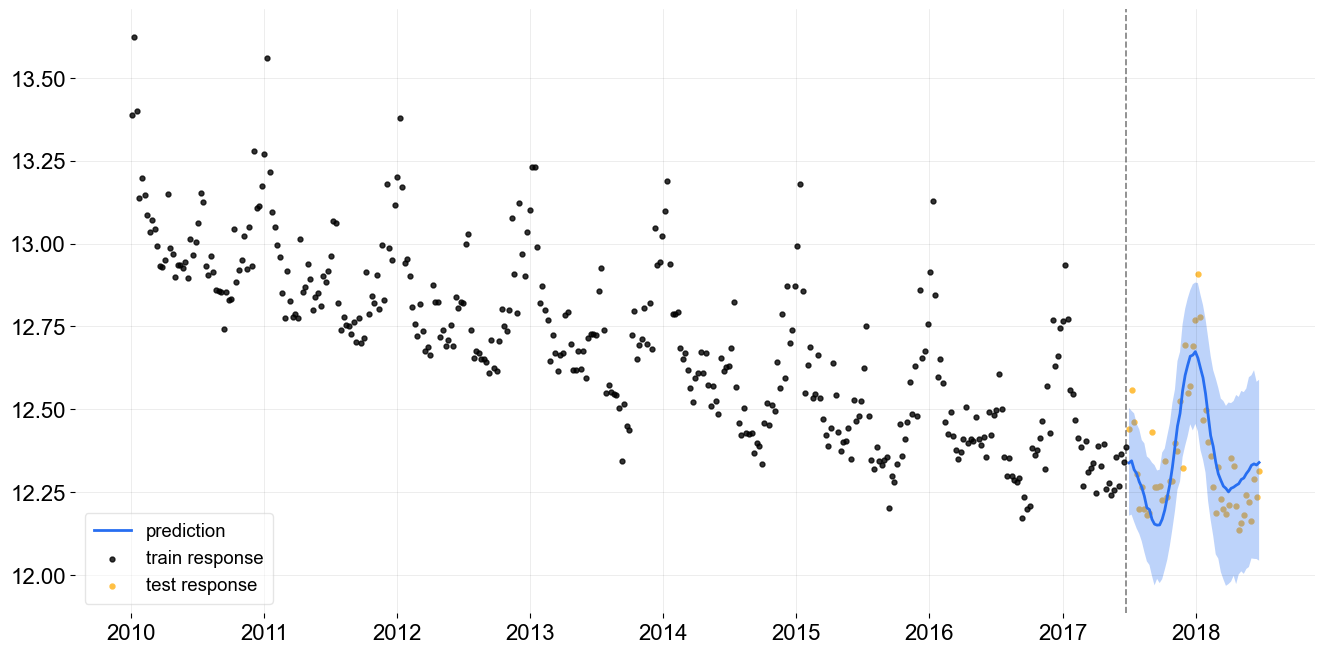

In [17]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

### multiple regression_segments

Change `regression_segments=0` args to `regression_segments=5`.

In [18]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    # regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    regressor_col=['trend.unemploy'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1,
    ktrlite_optim_args = dict()
)

In [19]:
ktr.fit(train_df)

INFO:root:Guessed max_plate_nesting = 1


In [20]:
ktr.get_regression_coefs().head()

,week,trend.unemploy
0,2010-01-03,0.10386
1,2010-01-10,0.10377
2,2010-01-17,0.10367
3,2010-01-24,0.10357
4,2010-01-31,0.10348


In [21]:
ktr.get_regression_coef_knots()

,week,step,trend.unemploy
0,2010-01-03,0,0.11035
1,2011-07-03,78,0.08710
2,2012-12-30,156,0.11927
3,2014-06-29,234,0.06504
4,2015-12-27,312,0.09255
5,2017-06-25,390,0.13490


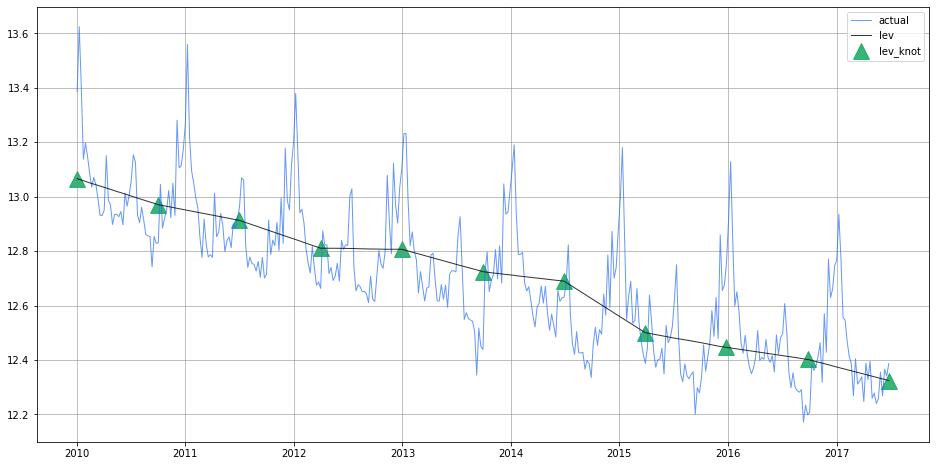

In [22]:
ktr.plot_lev_knots(figsize=(16, 8), use_orbit_style=False);

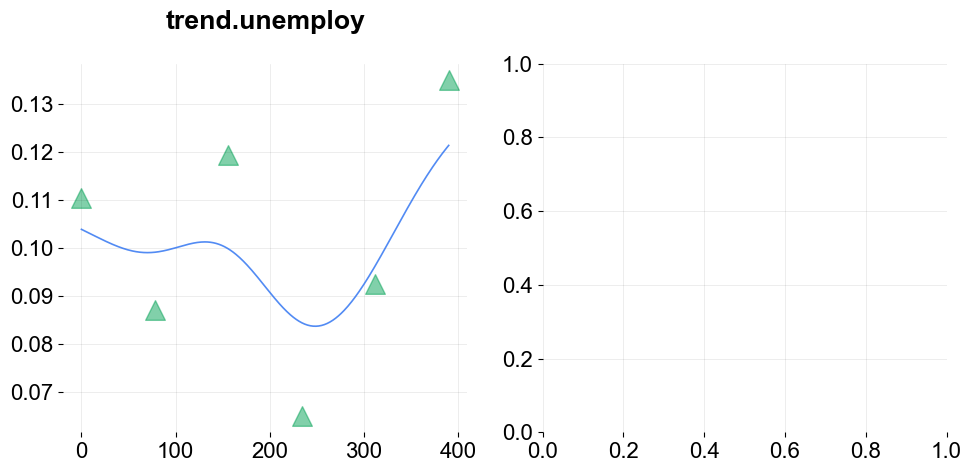

In [23]:
ktr.plot_regression_coefs(with_knot=True, figsize=(10, 5), include_ci=False);

In [24]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.head()

,week,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,regression_5,regression,regression_95,seasonality_52_5,seasonality_52,seasonality_52_95
0,2017-07-02,12.17602,12.33509,12.49622,12.16346,12.32028,12.48274,0.00148,0.02692,0.05021,-0.01367,-0.01367,-0.01367
1,2017-07-09,12.17908,12.33787,12.48704,12.16675,12.32876,12.48605,0.00170,0.03087,0.05757,-0.02090,-0.02090,-0.02090
2,2017-07-16,12.15634,12.31097,12.47849,12.16617,12.32353,12.48354,0.00126,0.02284,0.04260,-0.03211,-0.03211,-0.03211
3,2017-07-23,12.13226,12.29340,12.45650,12.15828,12.31989,12.48232,0.00114,0.02075,0.03869,-0.04732,-0.04732,-0.04732
4,2017-07-30,12.12414,12.27593,12.43266,12.16706,12.32113,12.47936,0.00126,0.02284,0.04260,-0.06621,-0.06621,-0.06621


In [25]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.71%'

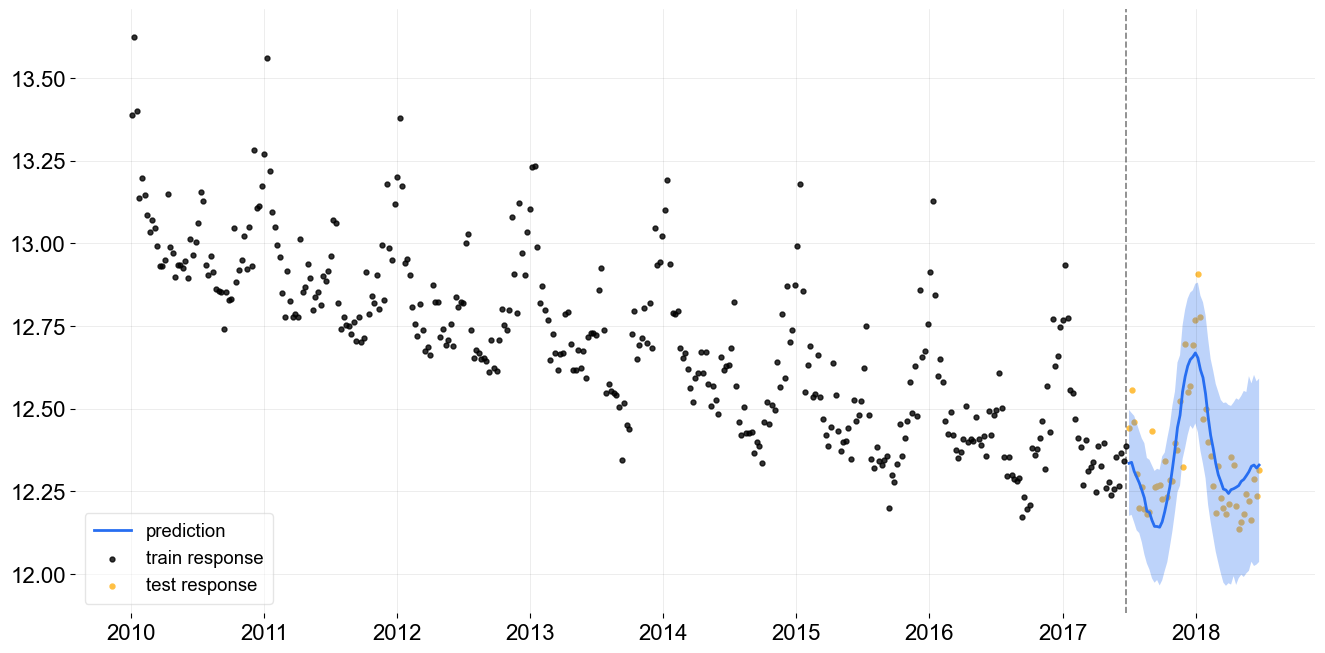

In [26]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

In [27]:
knot_df = ktr.get_regression_coef_knots()
knot_df

,week,step,trend.unemploy
0,2010-01-03,0,0.11035
1,2011-07-03,78,0.08710
2,2012-12-30,156,0.11927
3,2014-06-29,234,0.06504
4,2015-12-27,312,0.09255
5,2017-06-25,390,0.13490


### KTR - Median

INFO:root:Guessed max_plate_nesting = 1


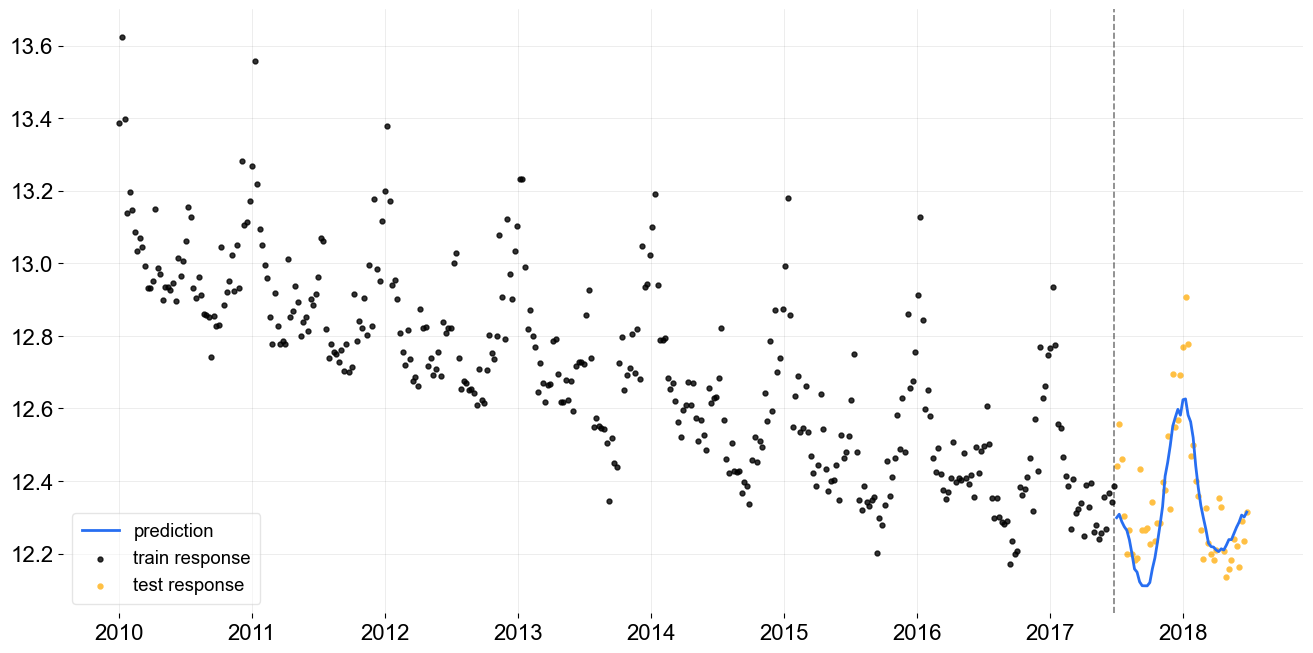

In [28]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    regressor_col=['trend.unemploy', 'trend.filling', 'trend.job'],
    seasonality=[52],
    seasonality_fs_order=[3],
    level_knot_scale=.1,
    level_segments=10,
    seasonality_segments=2,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

ktr.fit(df=train_df, point_method='median')
ktr.get_regression_coefs().head()

predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df)

## Electricity data (dual seasoanlity, no regressor)

In [29]:
# from 2000-01-01 to 2008-12-31
df = load_electricity_demand()

df['electricity'] = np.log(df['electricity'])

DATE_COL = 'date'
RESPONSE_COL = 'electricity'

print(df.shape)
df.head()

(3288, 2)


,date,electricity
0,2000-01-01,9.43760
1,2000-01-02,9.50130
2,2000-01-03,9.63565
3,2000-01-04,9.65392
4,2000-01-05,9.66089


In [30]:
test_size = 365

train_df = df[:-test_size]
test_df = df[-test_size:]

In [31]:
ktr = KTR(
    date_col=DATE_COL,
    response_col=RESPONSE_COL,
    seasonality=[7, 365.25],
    seasonality_fs_order=[2, 5],
    level_knot_scale=.1,
    level_segments=20,
    seasonality_segments=3,
    regression_segments=5,
    regression_rho=0.15,
    # pyro optimization parameters
    seed=8888,
    num_steps=1000,
    num_sample=1000,
    learning_rate=0.1,
    estimator='pyro-svi',
    n_bootstrap_draws=-1
)

In [32]:
ktr.fit(df=train_df, point_method='median')

INFO:root:Guessed max_plate_nesting = 1


In [33]:
predicted_df = ktr.predict(df=test_df, decompose=True)
predicted_df.tail()

,date,prediction,trend,regression,seasonality_7,seasonality_365.25
360,2008-12-27,9.97291,9.99328,0.00000,-0.02937,0.00900
361,2008-12-28,9.91402,9.99328,0.00000,-0.08773,0.00846
362,2008-12-29,9.97976,9.99328,0.00000,-0.02162,0.00810
363,2008-12-30,10.04459,9.99328,0.00000,0.04336,0.00794
364,2008-12-31,10.02630,9.99328,0.00000,0.02505,0.00797


In [34]:
f"SMAPE: {smape(predicted_df['prediction'].values, test_df[RESPONSE_COL].values):.2%}"

'SMAPE: 0.49%'

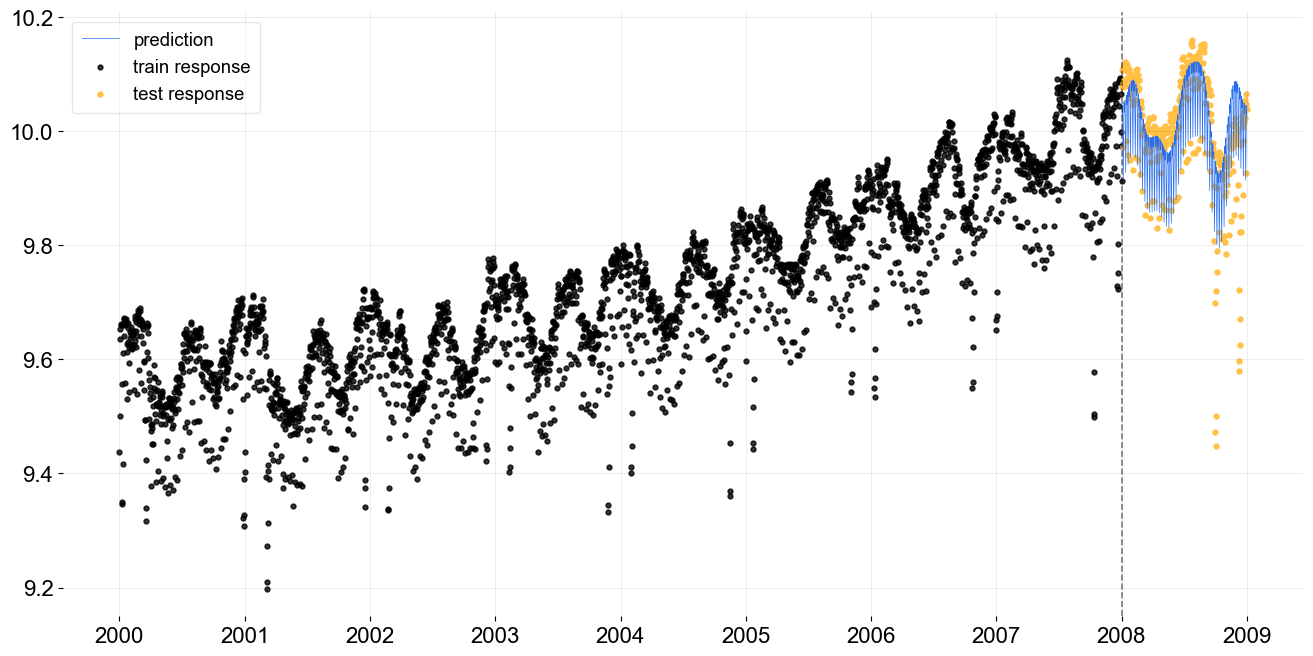

In [35]:
_ = plot_predicted_data(training_actual_df=train_df,
                        predicted_df=predicted_df,
                        date_col=DATE_COL,
                        actual_col=RESPONSE_COL,
                        test_actual_df=test_df,
                       lw=0.5)